In [1]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [2]:
utterance = '''Philipp:  Okay. It's now being recorded. So then let's get started  and start with Ivan.  Ivan: Yes, good morning everybody.  So, yesterday,  I have started working on the  implementation.  Nothing started, but continued working on implementation on gauge icon.  I had small discussion with Philip about some obstacles there.  I would need some input from you Marco, or you Flavia.  I don't know if you  guys, catch up the ticket.  And  after that,  we had like a pre-planning session  life  for the first time ever.  It was awesome. And yeah,  so today  I'm going to continue with the gauge icon and I have some ship  shipment to  probably do that in the second part of the day.  That's it.  Philipp: Awesome.  Yep. And so that it's in there and mentioned you  guys Marco and Flavia on Gitlab  and in the thicket regarding the go check. Maybe Ivan can you shortly share  the link in development Channel  or so?  Just to keep these guys in the loop,  then we will continue with Djuradj.'''
summary = '''Ivan has started working on the implementation of gauge icon yesterday. He needs some input from Marco and Flavia. Philipp will share the link in development Channel.'''

In [3]:
input_tokens = list(tokenizer.convert_ids_to_tokens(tokenizer.encode(utterance)))
output_tokens = list(tokenizer.convert_ids_to_tokens(tokenizer.encode(summary)))

In [4]:
import numpy as np
output_dict = {f'{token}_{i}': np.zeros(len(input_tokens)) for i,token in enumerate(output_tokens)}

In [5]:
for i, i_token in enumerate(input_tokens):
    if len(i_token) < 3 : continue
    output_keys = [i for i in list(output_dict.keys()) if i.split('_')[0] == i_token]
    if len(output_keys) > 0:
        for key in output_keys:
            output_dict[key][i] = 1

In [6]:
import pandas as pd
df = pd.DataFrame(output_dict) 
df.index = input_tokens

<AxesSubplot:>

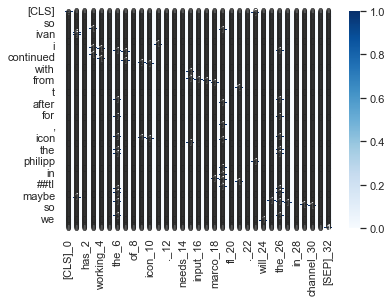

In [7]:
import seaborn as sns 
sns.set(rc={"figure.figsize":(20, 20)})
sns.heatmap(df, cmap = 'Blues', annot = True)

In [8]:
d = {}
for in_index in range(len(input_tokens)):
    i,o, = in_index, 0
    cur_index_range = []
    curr_str = []

    while i < len(input_tokens) and o < len(output_tokens):
        if input_tokens[i] == output_tokens[o]:
            cur_index_range.append(i)
            curr_str.append(input_tokens[i])
            i, o = i+1, o+1
        else:
            if i-1 in cur_index_range:
                i += 1
            elif len(curr_str) > 0:
                d['_'.join([str(i) for i in cur_index_range])] = curr_str
                cur_index_range = []
                curr_str = []
                o += 1
            else:
                o += 1

In [14]:
'. '.join([ ' '.join(i) for i in list(d.values()) if len(i) > 1 and len(i) < 4])

'on the implementation. the implementation. working on. gauge icon. input from marco. from marco. fl ##avia .. ##avia .. gauge icon. and fl ##avia. fl ##avia. in development channel. development channel'